# Evaluation of the model under different SNR values

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchnet.meter as tnt
import importlib

from scipy.io.wavfile import write
import IPython

sys.path.append('../')
sys.path.append('../datasets')
sys.path.append(os.path.join(os.getcwd(), '../models/'))

import ai8x
from kws20 import KWS
import kws20

In [2]:
data_path = '/home/emretopcu/ai8x-training/data'

class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit
        self.truncate_testset = False

simulate = False
args = Args(act_mode_8bit=simulate)

_ ,test_set = kws20.KWS_20_get_datasets((data_path, args), load_train=False, load_test=True)

Exception ignored in: <_io.FileIO name=65 mode='rb' closefd=True>
Traceback (most recent call last):
  File "/home/emretopcu/ai8x-training/venv/lib/python3.8/site-packages/audioread/__init__.py", line 99, in available_backends
    if ffdec.available():
Exception ignored in: <_io.FileIO name=67 mode='rb' closefd=True>
Traceback (most recent call last):
  File "/home/emretopcu/ai8x-training/venv/lib/python3.8/site-packages/audioread/__init__.py", line 99, in available_backends
    if ffdec.available():


No key `stretch` in input augmentation dictionary! Using defaults: [Min: 0.8, Max: 1.3]
Processing the label: backward. 1 of 36


Finished in 0.344 seconds.
Processing the label: bed. 2 of 36
Finished in 0.314 seconds.
Processing the label: bird. 3 of 36
Finished in 0.321 seconds.
Processing the label: cat. 4 of 36
Finished in 0.315 seconds.
Processing the label: dog. 5 of 36
Finished in 0.330 seconds.
Processing the label: down. 6 of 36
Finished in 0.611 seconds.
Processing the label: eight. 7 of 36
Finished in 0.591 seconds.
Processing the label: five. 8 of 36
Finished in 0.626 seconds.
Processing the label: follow. 9 of 36
Finished in 0.244 seconds.
Processing the label: forward. 10 of 36
Finished in 0.241 seconds.
Processing the label: four. 11 of 36
Finished in 0.577 seconds.
Processing the label: go. 12 of 36
Finished in 0.598 seconds.
Processing the label: happy. 13 of 36
Finished in 0.318 seconds.
Processing the label: house. 14 of 36
Finished in 0.328 seconds.
Processing the label: learn. 15 of 36
Finished in 0.245 seconds.
Processing the label: left. 16 of 36
Finished in 0.593 seconds.
Processing the la

In [4]:
classes = ['up', 'down', 'left', 'right', 'stop', 'go', 'yes', 'no', 'on', 'off', 'one',
                   'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'zero',
                   'UNKNOWN']

In [5]:
print("Number of samples in the test dataset    :",len(test_set))
print("Number of labels in the test dataset     :",len(classes))
print("Each sample contains a tuple with size   :",len(test_set[0]))
print("Height of the signal in the test dataset :",len(test_set[0][0]))
print("Width of each signal in the test dataset :",len(test_set[0][0][0]))


Number of samples in the test dataset    : 12161
Number of labels in the test dataset     : 21
Each sample contains a tuple with size   : 2
Height of the signal in the test dataset : 128
Width of each signal in the test dataset : 128


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Working with device:", device)

ai8x.set_device(device=85, simulate=simulate, round_avg=False)

Working with device: cuda
Configuring device: MAX78000, simulate=False.


In [7]:
# Existing version
strategy_a = os.path.join("..", ".." ,"ai8x-synthesis", "trained", "ai85-kws20-qat8.pth.tar")
# Updated DataLoader
strategy_b = os.path.join("..", "logs", "yeni_yeni_merve", "qat_best.pth.tar")
# Updated DataLoader + Utterance Detector
strategy_c = os.path.join("..", "logs", "2023.09.20-170138", "qat_best.pth.tar")
# Updated DataLoader + Utterance Detector + 66% augment chance
strategy_d = os.path.join("..", "logs", "2023.09.25-120647", "qat_best.pth.tar")
strats = [strategy_a, strategy_b, strategy_c, strategy_d]

In [8]:
mod = importlib.import_module("ai85net-kws20")
model = mod.AI85KWS20Net(num_classes=len(classes), num_channels=128, dimensions=(128, 1), bias=False, 
                           quantize_activation=False)

In [9]:
def plot_audio(data, target, snr = None):
    plt.plot(data)
    if snr != None:
        plt.title("Noisy", classes[target])
        plt.legend("SNR: ", snr)
    else:
        plt.title(classes[target])
    plt.ylabel("Amplitude")
    plt.xlabel("Time")
    plt.show()

In [10]:
def random_sample(data_type):
    if data_type == 'train':
        sample_index = np.random.randint(0,len(train_set))

        sample, target = train_set[sample_index]
        print(f'target: {target}, sample index: {sample_index}')
    if data_type == 'test':
        sample_index = np.random.randint(0,len(test_set))

        sample, target = test_set[sample_index]
        print(f'target: {target}, sample index: {sample_index}')
    return sample, target, sample_index

In [11]:
def snr_mixer2(audio, snr):
    """
    Mix clean and noise with provided SNR level.
    """
    eps = 1e-8
    #audio = torch.from_numpy(audio)
    signal_pwr = torch.var(audio)
    snr_linear = torch.tensor(10**(snr / 10), dtype=torch.float32)
    n_var = signal_pwr / snr_linear
    noise = torch.randn(audio.shape) * torch.sqrt(n_var)
    noisy_signal = audio + noise
    max_abs_noise = torch.max(torch.abs(noisy_signal))

    # Normalize the noise tensor
    if max_abs_noise > 1:
        noisy_signal /= max_abs_noise
    return noisy_signal

In [12]:
def evaluate(model, test_data, snr):

    model.to(device)
    classerr = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(len(classes), 5)))
    model.eval()

    with torch.no_grad():
        for validation_step, (inputs, targets) in enumerate(test_data):
            inputs = snr_mixer2(inputs,snr)
            inputs = inputs.unsqueeze(0)
            inputs = inputs.to(device)
        
            # compute output from model
            output = model(inputs)
            classerr.add(output, targets)
            if validation_step % 1000 == 0:
                print("Batch: [",validation_step ,"/", len(test_data),"]")
                acc = classerr.value()[0]
                print("Accuracy: ", acc)
        acc = classerr.value()[0]
        print("Total Accuracy: ", acc)
        
    return acc

In [13]:
accuracies = np.zeros((len(strats),17))

for i,strat in enumerate(strats):
    print("Started evaluating :", strat)
    checkpoint = torch.load(strat)
    model.load_state_dict(checkpoint['state_dict'], strict=False)
    ai8x.update_model(model)

    snr_low = torch.tensor(0, dtype=torch.int32)
    snr_high = torch.tensor(51, dtype=torch.int32)
    cnt = 0

    for db in range(snr_low, snr_high):
        if db <= 20:
            if db % 2 == 0:
                print("Evaluating SNR levels of", db)
                accuracies[i][cnt] = evaluate(model, test_set, db)
                cnt += 1
        else:
            if  db % 5 == 0:
                print("Evaluating SNR levels of", db)
                accuracies[i][cnt] = evaluate(model, test_set, db)
                cnt += 1

Started evaluating : ../logs/2023.09.25-120647/qat_best.pth.tar
Evaluating SNR levels of 0
Batch: [ 0 / 12161 ]
Accuracy:  0.0
Batch: [ 1000 / 12161 ]
Accuracy:  49.150849150849155
Batch: [ 2000 / 12161 ]
Accuracy:  67.1664167916042
Batch: [ 3000 / 12161 ]
Accuracy:  68.94368543818727
Batch: [ 4000 / 12161 ]
Accuracy:  68.55786053486628
Batch: [ 5000 / 12161 ]
Accuracy:  70.32593481303739
Batch: [ 6000 / 12161 ]
Accuracy:  72.20463256123979
Batch: [ 7000 / 12161 ]
Accuracy:  73.2466790458506
Batch: [ 8000 / 12161 ]
Accuracy:  74.7031621047369
Batch: [ 9000 / 12161 ]
Accuracy:  75.03610709921121
Batch: [ 10000 / 12161 ]
Accuracy:  75.94240575942406
Batch: [ 11000 / 12161 ]
Accuracy:  75.88401054449596
Batch: [ 12000 / 12161 ]
Accuracy:  75.7853512207316
Total Accuracy:  75.7853512207316
Evaluating SNR levels of 2
Batch: [ 0 / 12161 ]
Accuracy:  100.0
Batch: [ 1000 / 12161 ]
Accuracy:  55.044955044955046
Batch: [ 2000 / 12161 ]
Accuracy:  71.56421789105447
Batch: [ 3000 / 12161 ]
Accurac

In [17]:
accuracies = np.array([[66.73332821, 72.79440043, 76.77870933, 80.35535728, 82.70133067,
        84.59349281, 85.6472579 , 86.71640643, 87.78555496, 88.23167449,
        88.90085378, 89.83924314, 90.22382894, 90.78532421, 90.83916622,
        90.95454196, 90.91608338],
       [75.23539705, 80.19331722, 83.50137489, 85.45954504, 87.34272144,
        87.96766936, 88.60094992, 89.15923673, 89.33422215, 89.46754437,
        89.64252979, 89.8591784 , 89.81751521, 89.99250062, 89.90917424,
        89.89250896, 90.12582285],
       [75.90200816, 79.69335889, 83.35138738, 86.03449713, 87.29272561,
        88.48429298, 89.16756937, 89.35922006, 89.97583535, 90.0508291 ,
        90.10082493, 90.29247563, 90.23414715, 90.48412632, 90.3508041 ,
        90.26747771, 90.3508041 ],
       [75.78535122, 80.97658528, 84.62628114, 86.93442213, 88.65094575,
        89.26756104, 90.35913674, 91.07574369, 91.08407633, 91.484043  ,
        91.41738188, 91.72568953, 92.03399717, 92.083993  , 91.95067078,
        92.03399717, 92.06732772]
        ])


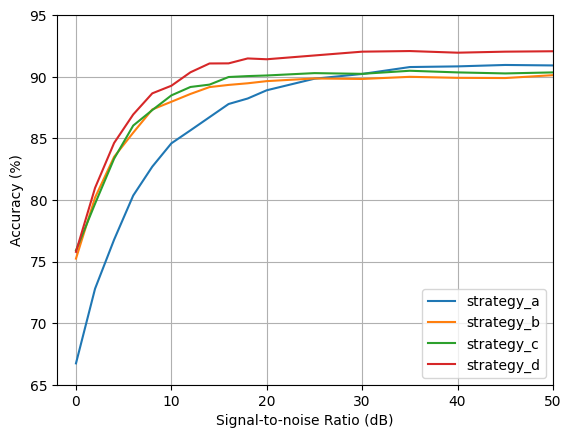

In [18]:
snr_db = np.array([0,2,4,6,8,10,12,14,16,18,20,25,30,35,40,45,50])
plt.plot(snr_db,accuracies[0], label = "strategy_a")
plt.plot(snr_db,accuracies[1], label = "strategy_b")
plt.plot(snr_db,accuracies[2], label = "strategy_c")
plt.plot(snr_db,accuracies[3], label = "strategy_d")
plt.xlim((-2, 50))
plt.ylim((65, 95))
plt.xlabel('Signal-to-noise Ratio (dB)')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()